# Encoder

In [ ]:
"""
Pre-trained ResNet-50 architecture (with the final fully-connected layer removed)
To extract features from a batch of pre-processed images

input = [32,3,299,299]. images[batch_size, color, width, height] embed_size == 256
output = torch.Size([32, 256])   [batch_size X embed_size ]
""" 

import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For every step--> process it:


  *   feature shape [batch_size,embedding_size] (20 X 128)
  *   caption shape [batch_size,[link text](https://) time_step] (3,1)


after embedding layer, caption shape [batch_size, time_step, embedding] [3 X 

*   after embedding layer, caption shape [batch_size, time_step, embedding] [3 X 1 X 128]

*   after sequeeze, features shape [batch_size, time_step, embedding] [20 X 1 X 128]
*   connect [sample_size, time_step, vocab_size ]



# Decoder

In [ ]:
# feed features from CNN and captions (sqeuence) as input into RNN (LSTM) input shape
# input(features) from CNN [batch_size, embedding_size]  input(captions) from dataset [seq_len,batch_size]
# convert both into same dimension [1, batch_size, embedding_size] and [seq_len,batch_size, embedding_size]
# captions (squence) as outputs
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size

        # for captions
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        
        # batch, seq, feature
        # self.lstm = nn.LSTM(embed_size, hidden_size,num_layers, batch_first = True)
        
        self.lstm = nn.LSTM(embed_size, hidden_size,num_layers)
        # seq, batch, feature
        # take last hidden state
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        # initilize the hidden an cell states to zeros
        batch_size = features.shape[0]
        hidden_state = torch.zeros((1, batch_size, self.hidden_size)).cuda()
        cell_state  = torch.zeros((1, batch_size, self.hidden_size)).cuda()


        # first embeddinig layer. Map the word to some dimensional space to have a better representation of the word
        # it is gonna take an index and map it to embed size
        # view it as the first word that input to the LSTM
        # embed: [seq_len,batch_size,embedding_size]
        embed = self.embedding_layer(captions)
        # add one dimension here so it is viewed as time step
        # contenanent with embeddings which already have time step
        # rows contenanent
        embed = torch.cat((features.unsqueeze(0), embed), dim = 0)
      
        # _ = (hidden_state, cell_state)
        # using the target captions as actual input for every time step
        # it is making some predictions which are going to be used in loss function
        lstm_outputs, (hidden_state, cell_state) = self.lstm(embed, (hidden_state, cell_state))
        out = self.linear(lstm_outputs)
        return out

    ## Greedy search 
    # img features as inputs, captions as outputs

    def caption_image(self, inputs, vocabulary, max_length):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        result_caption = []
        with torch.no_grad():
            # inputs = self.encoderCNN(image).unsqueeze(0)
            # batch_size = inputs.shape[0] # inputs shape : (1, 1, embed_size)  (batch_size, time_step , embed_size)
            states = None # hidden and cell state for the LSTM, initially set as None
        
            for _ in range(max_length):
                lstm_out, states = self.lstm(inputs, states) # lstm_out shape : (1, 1, hidden_size)
                outputs = self.linear(lstm_out.squeeze(0))  # outputs shape : (1, 1, vocab_size)
                # outputs = outputs.squeeze(0) # outputs shape : (1, vocab_size)
                predicted = outputs.argmax(1) # take the word with highest probability
                
                result_caption.append(predicted.item()) #  convert into a Python number from a tensor containing a single value:
                inputs = self.embedding_layer(predicted).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    # We predicted the <end> word, so there is no further prediction to do
                    break

                
        return [vocabulary.itos[idx] for idx in result_caption]



# Data_Preprocess

In [ ]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  #Load img
import torchvision.transforms as transforms


spacy_eng = spacy.load("en")


class Vocabulary:
    def __init__(self, freq_threshold):
        # convert index to string
        # convert string to index
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    # for example, if "you are studying" --> "you", "are", "studying"

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        # all caption in list
        for sentence in sentence_list:
            # each word in each caption
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                # if the frequency is more than freq_threshold. then include it into vocabulary
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            # if in stoi(which means included in vocabulary), then return index of tokens
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=4):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())
        self.caption_lengths = len(self.vocab)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

# if __name__ == "__main__":
#     transform = transforms.Compose(
#         [transforms.Resize((224, 224)), transforms.ToTensor(),]
#     )

#     loader, dataset = get_loader(
#         "/content/drive/MyDrive/Colab_Notebooks/Image_captioning_dataset/flickr8k/images", "/content/drive/MyDrive/Colab_Notebooks/Image_captioning_dataset/flickr8k/captions.txt", transform=transform
#     )
#     # torch.Size([32, 3, 224, 224])
#     # torch.Size([28, 32])
#     # torch.Size([23, 32])
#     for idx, (imgs, captions) in enumerate(loader):
#         print(imgs.shape)
#         print(captions.shape)
#         print(type(captions))

# Training

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
import math
# from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

transform_train = transforms.Compose([ 
    transforms.Resize(356),                          # smaller edge of image resized to 256
    transforms.RandomCrop(299),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])# normalize image for pre-trained model


train_loader, dataset = get_loader(
    root_folder="/content/drive/MyDrive/Colab_Notebooks/Image_captioning_dataset/flickr8k/images",
    annotation_file="/content/drive/MyDrive/Colab_NotebooksImage_captioning_dataset/flickr8k/captions.txt",
    transform=transform_train,
    num_workers=2,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = False
train_CNN = False

# # for tensorboard
# writer = SummaryWriter("runs/flickr")
# step = 0

# Hyperparameters
batch_size = 32          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 256          # number of features in hidden state of the RNN decoder
num_epochs = 100             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity
learning_rate = 3e-4

# The size of the vocabulary.
vocab_size = len(dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

# if load_model:
#     step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

encoder.train()
decoder.train()

# total_step = math.ceil(dataset.caption_lengths / train_loader.batch_size)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


DecoderRNN(
  (embedding_layer): Embedding(3432, 256)
  (lstm): LSTM(256, 256)
  (linear): Linear(in_features=256, out_features=3432, bias=True)
)

In [ ]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time
from tqdm import tqdm 


for epoch in range(1, num_epochs+1):
    print_examples(encoder, decoder, device, dataset)
    # for idx, (imgs, captions) in tqdm(
    #     enumerate(train_loader), total=len(train_loader), leave=False
    # ):
    for idx, (images, captions) in (enumerate(train_loader)):
        # Obtain the batch.
        # images, captions = next(iter(train_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        
        # Pass the inputs through the CNN-RNN model.
        # caption shape [batch_size, time_step] (3,1)


        features = encoder(images)
        # print(features.shape) # torch.Size([32, 256]) [1, 32, 256]
        # print(captions.shape) # torch.Size([25, 32])  [25, 32, 256]

        # print(features.shape) # torch.Size([32, 256]) [32, 1, 256]
        # print(captions.shape) # torch.Size([25, 32])  [32, 25, 256]
        # captions = captions.permute(1,0)
        outputs = decoder(features, captions[:-1])
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        # loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        # captions_shape: torch.Size([23, 32])
        # output of decoder = (batch, time_step, vocab_size)
        loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        # writer.add_scalar("Training loss", loss.item(), global_step=step)
        # step += 1

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Backward pass.
        loss.backward(loss)
        
        # Update the parameters in the optimizer.
        optimizer.step()

        # # Get training statistics.
        # stats = 'Epoch [%d/%d], Loss: %.4f' % (epoch, num_epochs, loss.item())
      
        # # Print training statistics (on different line).
        # if step % 1000 == 0:
        #     print('\r' + stats)
        #     sys.stdout.flush()
    stats = 'Epoch [%d/%d], Loss: %.4f' % (epoch, num_epochs, loss.item())
    print('\n' + stats)
      

torch.save(encoder.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/Image_captioning_dataset/trained_model/encoder-%d.pkl")       
torch.save(decoder.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/Image_captioning_dataset/trained/model/decoder-%d.pkl")   


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: begins flight fake come quad airborne shaved call appear kid faucet serve serve among costumes costumes fight cable green tulips suit dribbling motorbikes presses distance pyramid 2 dribbles moment wakeboarding trick ropes cable runner puppies whose sailing sledding sledding canoeing break placed hoop hoop to bounding pile larger hair beginning
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: led displays crab ! local creature sleeveless reeds apron puppies pacifier clapping throwing spray puts limo crevasse location surround wake advertising lie marked first stretches legs bunch buckets folding away footprints kid covers smiling barbed limb stack surrounding playhouse asphalt shining boa daughter praying butt ejected port beneath act feather
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: propped races mobile mark flight statue nails stadium limb ascending dusk tee bank pig right bi

IsADirectoryError: ignored

# Sample experiment

In [ ]:
def print_examples(encoder, decoder, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    data_dir = "/content/drive/MyDrive/Colab_Notebooks/Image_captioning_dataset/"
    encoder.eval()
    decoder.eval()
    test_img1 = transform(Image.open(data_dir+"test_examples/dog.jpg").convert("RGB")).unsqueeze(
        0
    )
    test_img1 = test_img1.to(device)
    features1 = encoder(test_img1).unsqueeze(0)
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(decoder.caption_image(features1, dataset.vocab, 50))
    )
    test_img2 = transform(
        Image.open(data_dir+"child.jpg").convert("RGB")
    ).unsqueeze(0)
    test_img2 = test_img2.to(device)
    features2 = encoder(test_img2).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(decoder.caption_image(features2, dataset.vocab, 50))
    )
    test_img3 = transform(Image.open(data_dir+"bus.png").convert("RGB")).unsqueeze(
        0
    )
    test_img3 = test_img3.to(device)
    features3 = encoder(test_img3).unsqueeze(0)
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(decoder.caption_image(features3.to(device), dataset.vocab, 50))
    )
    test_img4 = transform(
        Image.open(data_dir+"boat.png").convert("RGB")
    ).unsqueeze(0)
    test_img4 = test_img4.to(device)
    features4 = encoder(test_img4).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(decoder.caption_image(features4.to(device), dataset.vocab, 50))
    )
    test_img5 = transform(
        Image.open(data_dir+"horse.png").convert("RGB")
    ).unsqueeze(0)
    test_img5 = test_img5.to(device)
    features5 = encoder(test_img5).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(decoder.caption_image(features5.to(device), dataset.vocab, 50))
    )
    encoder.train()
    decoder.train()


Virtualization



Epoch [90/100], Loss: 0.9988


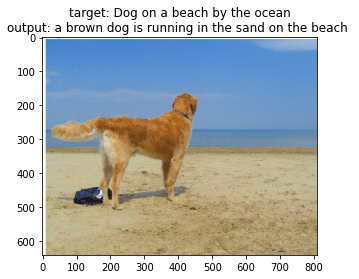

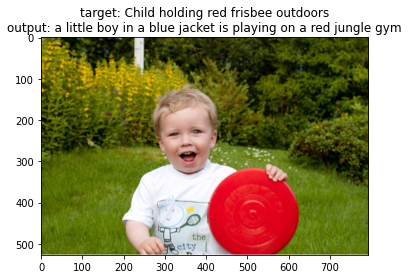

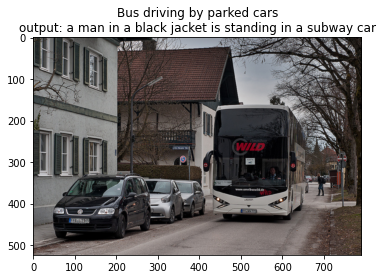

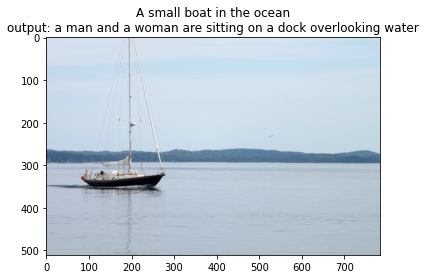

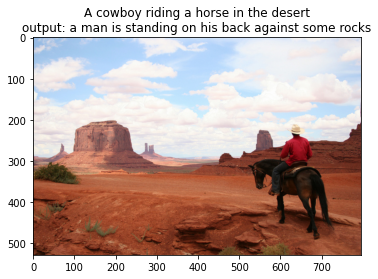

In [ ]:
# Epoch [95/100], Loss: 1.3270
# Example 1 CORRECT: Dog on a beach by the ocean
# Example 1 OUTPUT: <SOS> a dog is running on the shore of a lake . <EOS>
# Example 2 CORRECT: Child holding red frisbee outdoors
# Example 2 OUTPUT: <SOS> a little boy in a blue shirt is running on a path in the grass . <EOS>
# Example 3 CORRECT: Bus driving by parked cars
# Example 3 OUTPUT: <SOS> a man is pulling a cart on a road in a parking lot <EOS>
# Example 4 CORRECT: A small boat in the ocean
# Example 4 OUTPUT: <SOS> a man is fishing in the ocean at dusk . <EOS>
# Example 5 CORRECT: A cowboy riding a horse in the desert
# Example 5 OUTPUT: <SOS> a man is standing on his back against some rocks . <EOS>

# Epoch [90/100], Loss: 0.9988
# Example 1 CORRECT: Dog on a beach by the ocean
# Example 1 OUTPUT: <SOS> a brown dog is running in the sand on the beach . <EOS>
# Example 2 CORRECT: Child holding red frisbee outdoors
# Example 2 OUTPUT: <SOS> a little boy in a blue jacket is playing on a red jungle gym . <EOS>
# Example 3 CORRECT: Bus driving by parked cars
# Example 3 OUTPUT: <SOS> a man in a black jacket is standing in a subway car . <EOS>
# Example 4 CORRECT: A small boat in the ocean
# Example 4 OUTPUT: <SOS> a man and a woman are sitting on a dock overlooking water . <EOS>
# Example 5 CORRECT: A cowboy riding a horse in the desert
# Example 5 OUTPUT: <SOS> a man is standing on his back against some rocks . <EOS>

# Epoch [82/100], Loss: 1.5133
# Example 1 CORRECT: Dog on a beach by the ocean
# Example 1 OUTPUT: <SOS> a brown dog is running on a beach with its mouth wide open . <EOS>
# Example 2 CORRECT: Child holding red frisbee outdoors
# Example 2 OUTPUT: <SOS> a small child is running through a grassy area with trees in the background and fields in the background . <EOS>
# Example 3 CORRECT: Bus driving by parked cars
# Example 3 OUTPUT: <SOS> a street with a large backpack <UNK> . <EOS>
# Example 4 CORRECT: A small boat in the ocean
# Example 4 OUTPUT: <SOS> a woman stands on a dock , looking out the water . <EOS>

# Epoch [82/100], Loss: 1.5133
# Example 1 CORRECT: Dog on a beach by the ocean
# Example 1 OUTPUT: <SOS> a brown dog is running on a beach with its mouth wide open . <EOS>
# Example 2 CORRECT: Child holding red frisbee outdoors
# Example 2 OUTPUT: <SOS> a small child is running through a grassy area with trees in the background and fields in the background . <EOS>
# Example 3 CORRECT: Bus driving by parked cars
# Example 3 OUTPUT: <SOS> a street with a large backpack <UNK> . <EOS>
# Example 4 CORRECT: A small boat in the ocean
# Example 4 OUTPUT: <SOS> a woman stands on a dock , looking out the water . <EOS>

# Epoch [46/100], Loss: 1.5966
# Example 1 CORRECT: Dog on a beach by the ocean
# Example 1 OUTPUT: <SOS> a dog running in the sand <EOS>
# Example 2 CORRECT: Child holding red frisbee outdoors
# Example 2 OUTPUT: <SOS> a little boy in a blue shirt is playing with a soccer ball . <EOS>
# Example 3 CORRECT: Bus driving by parked cars
# Example 3 OUTPUT: <SOS> a man walking down the street with a black and white dog beside him . <EOS>
# Example 4 CORRECT: A small boat in the ocean
# Example 4 OUTPUT: <SOS> a man in a boat on the water . <EOS>
# Example 5 CORRECT: A cowboy riding a horse in the desert
# Example 5 OUTPUT: <SOS> a man is standing on his back against a blue sky with a backpack . <EOS>

print('Epoch [90/100], Loss: 0.9988')
# Example 1 CORRECT: Dog on a beach by the ocean
# Example 1 OUTPUT: <SOS> a brown dog is running in the sand on the beach . <EOS>
# Example 2 CORRECT: Child holding red frisbee outdoors
# Example 2 OUTPUT: <SOS> a little boy in a blue jacket is playing on a red jungle gym . <EOS>
# Example 3 CORRECT: Bus driving by parked cars
# Example 3 OUTPUT: <SOS> a man in a black jacket is standing in a subway car . <EOS>
# Example 4 CORRECT: A small boat in the ocean
# Example 4 OUTPUT: <SOS> a man and a woman are sitting on a dock overlooking water . <EOS>
# Example 5 CORRECT: A cowboy riding a horse in the desert
# Example 5 OUTPUT: <SOS> a man is standing on his back against some rocks . <EOS>

import matplotlib.pyplot as plt
import numpy as np
data_dir = "/content/drive/MyDrive/Colab_Notebooks/Image_captioning_dataset/"
PIL_image = Image.open(data_dir+"dog.jpg").convert('RGB')
orig_image = np.array(PIL_image)
plt.imshow(np.squeeze(orig_image))
plt.title('target: Dog on a beach by the ocean' + '\n'+ 'output: a brown dog is running in the sand on the beach ' )
plt.show()


PIL_image = Image.open(data_dir+"child.jpg").convert('RGB')
orig_image = np.array(PIL_image)
plt.imshow(np.squeeze(orig_image))
plt.title('target: Child holding red frisbee outdoors' + '\n'+ 'output: a little boy in a blue jacket is playing on a red jungle gym' )
plt.show()

PIL_image = Image.open(data_dir+"bus.png").convert('RGB')
orig_image = np.array(PIL_image)
plt.imshow(np.squeeze(orig_image))
plt.title('Bus driving by parked cars' + '\n'+ 'output: a man in a black jacket is standing in a subway car')
plt.show()

PIL_image = Image.open(data_dir+"boat.png").convert('RGB')
orig_image = np.array(PIL_image)
plt.imshow(np.squeeze(orig_image))
plt.title('A small boat in the ocean' + '\n'+ 'output: a man and a woman are sitting on a dock overlooking water')
plt.show()

PIL_image = Image.open(data_dir+"horse.png").convert('RGB')
orig_image = np.array(PIL_image)
plt.imshow(np.squeeze(orig_image))
plt.title('A cowboy riding a horse in the desert' + '\n'+ 'output: a man is standing on his back against some rocks')
plt.show()






# BLEU Score

In [ ]:
#https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

from nltk.translate.bleu_score import sentence_bleu
reference = [['Dog', 'on', 'a', 'beach','by','the','ocean']]
candidate = ['a', 'brown', 'dog', 'is', 'running', 'in', 'the', 'sand', 'on', 'the','beach']
score = sentence_bleu(reference, candidate)
print(score)


0.7765453555044466


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

reference = ['A', 'cowboy', 'riding', 'a', 'horse', 'in', 'the', 'desert'] 
candidate = ['a','man', 'is', 'standing', 'on', 'his', 'back', 'against', 'some', 'rocks']
score = sentence_bleu(reference, candidate)
print(score)

0.5623413251903491


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
